# Don't use this for anything. Much of it makes
# no sense as I was just messing around.

# Data Exploration
Do your work for these exercises in a file named explore.

In [1]:
# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

# Modeling
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# from env import path
from acquire import get_titanic_data
from prepare import prep_titanic_data

In [2]:
import io


def df_metadata(df) -> tuple:
    """
    return a tuple of (size, shape, info)
    """
    buffer = io.StringIO()
    df.info(buf=buffer)
    return (df.size, df.shape, buffer.getvalue())


def df_print_metadata(df) -> None:
    """
    print metadata of dataframe
    """
    size, shape, info = df_metadata(df)
    print("DATAFRAME METADATA")
    print(f"Size: {size}")
    print()
    print(f"Shape: {shape[0]} x {shape[1]}")
    print()
    print("Info:")
    print(info, end="")


def df_peek(df) -> tuple:
    """
    return head and tail of df
    """
    return df.head().append(df.tail())


def df_print_summary(df, columns=[]):
    """
    columns is a sequence of columns whose IQR and range will be 
    calculated
    
    If a user does not pass in a columns argument, then it will default 
    to an empty list. "if not columns" evaluates to True if columns is 
    an empty list. So if the user does not pass in a columns argument, 
    the function will default to printing a summary for every column in 
    the dataframe.
    The reason Michael put a columns parameter in here is that the 
    function will blow up with an error when it attempts to summarize 
    a column with non-numerical data.
    """
    if not columns:
        columns = df.columns
    print("SUMMARY")
    description = df.describe()
    print("Description:")
    print(description)
    print()
    print("IQR:")
    for col in columns:
        print(
            f"\t{col}: {description.loc['75%', col] - description.loc['25%', col]}"
        )
    print()
    print("Range:")
    for col in columns:
        print(f"\t{col}: {df[col].max() - df[col].min()}")


def series_is_whole_nums(series):
    try:
        return (series % 1 == 0).all()
    except TypeError:
        return False


def df_float_to_int(df):
    """
    Checks each column to see if it's whole numbers first.
    If a column is whole numbers, then sets the value of that
    column's dictinary entry to int.
    Finally calls the astype function using that to_coerce dictionary
    so that only the whole number columns are converted to integers.
    The entries with blank values in to_coerce are ignored.
    """
    to_coerce = {}
    for col in df.columns:
        if series_is_whole_nums(df[col]):
            to_coerce[col] = int
    return df.astype(to_coerce)


def df_print_missing_vals(df):
    # any missing values?
    # prints the number of missing values 
    # only for columns with missing values
    print("\nMissing Values:\n")
    null_counts = df.isnull().sum()
    if len(null_counts[null_counts > 0]) == 0:
        print("No missing values")
    else:
        print(null_counts[null_counts > 0])


def df_percent_missing_vals(df):
    return (df.isnull().sum() / df.shape[0]) * 100


def df_drop_cols(df, to_drop):
    return df.drop(columns=to_drop)


def df_remove_outliers(df, cols, zscore_limit):
    df_clean = None
    for col in cols:
        df_clean = df[
            (np.abs(stats.zscore(df[cols])) < zscore_limit).all(axis=1)
        ]
    return df_clean


def df_print_r_and_p_values(X, y):
    r_and_p_values = {col: stats.pearsonr(X[col], y) for col in X.columns}
    print("PEARSON'S R")
    for k, v in r_and_p_values.items():
        col = k
        r, p = v
        print(f"{col}:")
        print(f"\tPearson's R is {r:.2f} ")
        print(f"\twith a significance p-value of {p: .3}\n")


def linreg_fit_and_predict(x_train, y_train, x_test, y_test):
    # receives the train and test data
    # then returns the linear model and the predictions for the train
    # and test data.
    lm = LinearRegression()
    lm.fit(x_train, y_train)

    y_label = y_train.columns[0]
    y_intercept = lm.intercept_[0]
    m = lm.coef_[0][0]
    x_label = x_train.columns[0]
    print(f"Univariate: {y_label} = {y_intercept:.2f} + {m:.3}*{x_label}")
    print()

    preds_train = lm.predict(x_train)

    # run test data through model
    preds_test = lm.predict(x_test)

    return lm, preds_train, preds_test


def evaluate_model_train(x, y, preds):
    y_label = y.columns[0]
    x_label = x.columns[0]

    print("Model Evaluation on TRAIN Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE: {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE: {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(f"\t{r2:.2%} of the variance in {y_label} ")
    print(f"\t\tcan be explained by {x_label}.")
    print("\tP-VALUE of ", end='')
    f_vals, p_vals = f_regression(x, y)
    print(f"Train: {p_vals[0]:.3}")
    print()


def evaluate_model_test(x, y, preds):
    y_label = y.columns[0]
    x_label = x.columns[0]

    print("Model Evaluation on TEST Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE: {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE: {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(f"\t{r2:.2%} of the variance in {y_label} ")
    print(f"\t\tcan be explained by {x_label}.")
    print("\tP-VALUE of ", end='')
    f_vals, p_vals = f_regression(x, y)
    print(f"Test: {p_vals[0]:.3}")
    print()


def plot_residuals(y_test, preds_test):
    y_label = y_test.columns[0]
    plt.scatter(preds_test, preds_test - y_test, c="g", s=20)
    plt.hlines(y=0, xmin=preds_test.min(), xmax=preds_test.max())
    plt.title("Residual plot")
    plt.ylabel("Residuals")
    plt.xlabel(y_label)
    plt.show()


def linreg_model(x_train, y_train, x_test, y_test):
    lm, preds_train, preds_test = linreg_fit_and_predict(
                                    x_train, y_train, x_test, y_test)

    evaluate_model_train(x_train, y_train, preds_train)
    evaluate_model_test(x_test, y_test, preds_test)

    plot_residuals(y_test, preds_test)
    

def evaluate_multi_model_train(X, y, preds):
    y_label = y.columns[0]
    X_labels = X.columns

    print("Model Evaluation on TRAIN Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE (mean squared error): {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE (median absolute error): {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(f"\t{r2:.2%} of the variance in {y_label} ")
    print(f"\tcan be explained by {X_labels}.")

    print("P-VALUE of ", end='')
    f_vals, p_vals = f_regression(X, y)
    print(f"Train: {p_vals[0]:.3}")
    print()
    
def evaluate_multi_model_test(X, y, preds):
    y_label = y.columns[0]
    X_labels = X.columns

    print("Model Evaluation on TEST Data")
    meanse = mean_squared_error(y, preds)
    print(f"\tMSE (mean squared error): {meanse:.3f}")

    medianae = median_absolute_error(y, preds)
    print(f"\tMAE (median absolute error): {medianae:.3f}")

    r2 = r2_score(y, preds)
    print(f"\t{r2:.2%} of the variance in {y_label}")
    print(f"\tcan be explained by {X_labels}.")

    print("P-VALUE of ", end='')
    f_vals, p_vals = f_regression(X, y)
    print(f"Test: {p_vals[0]:.3}")
    print()
    
def multi_linreg_fit_and_evaluate(X_train, y_train, X_test, y_test):
    lm = LinearRegression()
    lm.fit(X_train, y_train)

    y_label = y_train.columns[0]
    y_intercept = lm.intercept_[0]
    print("Multivariate:")
    print(f"{y_label} = ")
    print(f"{y_intercept:.3f}")
    for i, col in enumerate(X_train.columns):
        coefficient = lm.coef_[0][i]
        print(f"+ {coefficient:.3}*{col}")

    preds_train = lm.predict(X_train)
    evaluate_multi_model_train(X_train, y_train, preds_train)
    
    preds_test = lm.predict(X_test)
    evaluate_model_test(X_test, y_test, preds_test)
    
    plot_residuals(y_test, preds_test) 
    print()


def normalize_cols(df_train, df_test, cols):
    df_train_norm = pd.DataFrame()
    for col in cols:
        minimum = df_train[col].min()
        maximum = df_train[col].max()
        df_train_norm[f"{col}_norm"] = (df_train[col] - minimum) / (maximum - minimum)
    
    df_test_norm = pd.DataFrame()
    for col in cols:
        minimum = df_train[col].min()  # use the min and max from the train set
        maximum = df_train[col].max()
        df_test_norm[f"{col}_norm"] = (df_test[col] - minimum) / (maximum - minimum)
    return df_train_norm, df_test_norm

In [3]:
df = get_titanic_data()

In [5]:
df = prep_titanic_data(df)

In [6]:
df_peek(df)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
0,0,0,3,male,22.0,1,0,7.2500,S,Third,Southampton,0,2
1,1,1,1,female,38.0,1,0,71.2833,C,First,Cherbourg,0,0
2,2,1,3,female,26.0,0,0,7.9250,S,Third,Southampton,1,2
3,3,1,1,female,35.0,1,0,53.1000,S,First,Southampton,0,2
4,4,0,3,male,35.0,0,0,8.0500,S,Third,Southampton,1,2
885,885,0,3,female,39.0,0,5,29.1250,Q,Third,Queenstown,0,1
886,886,0,2,male,27.0,0,0,13.0000,S,Second,Southampton,1,2
887,887,1,1,female,19.0,0,0,30.0000,S,First,Southampton,1,2
889,889,1,1,male,26.0,0,0,30.0000,C,First,Cherbourg,1,0
890,890,0,3,male,32.0,0,0,7.7500,Q,Third,Queenstown,1,1


In [7]:
df_print_metadata(df)

DATAFRAME METADATA
Size: 9282

Shape: 714 x 13

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
passenger_id       714 non-null int64
survived           714 non-null int64
pclass             714 non-null int64
sex                714 non-null object
age                714 non-null float64
sibsp              714 non-null int64
parch              714 non-null int64
fare               714 non-null float64
embarked           714 non-null object
class              714 non-null object
embark_town        714 non-null object
alone              714 non-null int64
embarked_encode    714 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 78.1+ KB


In [8]:
df.columns

Index(['passenger_id', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'embark_town', 'alone', 'embarked_encode'],
      dtype='object')

In [9]:
# take only the relevant columns from property DF
colnames = ['passenger_id', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'embark_town', 'alone', 'embarked_encode']
df_props = df[colnames] ## actually taking all the columns, so the same

In [10]:
df_print_missing_vals(df_props)


Missing Values:

No missing values


In [11]:
# % of NaNs in columns
df_percent_missing_vals(df_props).sort_values(ascending=False)

embarked_encode    0.0
alone              0.0
embark_town        0.0
class              0.0
embarked           0.0
fare               0.0
parch              0.0
sibsp              0.0
age                0.0
sex                0.0
pclass             0.0
survived           0.0
passenger_id       0.0
dtype: float64

In [12]:
df_dropped = df
# # drop columns
# to_drop = []
# df_dropped = df_drop_cols(df_props, to_drop)
# df_peek(df_dropped)

In [13]:
# remove rows with NaNs
df_nanless = df_dropped.dropna()
print(f"Dropped {df_dropped.shape[0] - df_nanless.shape[0]} rows.")
print()
df_print_metadata(df_nanless)

Dropped 0 rows.

DATAFRAME METADATA
Size: 9282

Shape: 714 x 13

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
passenger_id       714 non-null int64
survived           714 non-null int64
pclass             714 non-null int64
sex                714 non-null object
age                714 non-null float64
sibsp              714 non-null int64
parch              714 non-null int64
fare               714 non-null float64
embarked           714 non-null object
class              714 non-null object
embark_town        714 non-null object
alone              714 non-null int64
embarked_encode    714 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 78.1+ KB


In [14]:
# Convert variables to proper type
df_type_fix = df_float_to_int(df_nanless)
df_print_metadata(df_type_fix)

DATAFRAME METADATA
Size: 9282

Shape: 714 x 13

Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 714 entries, 0 to 890
Data columns (total 13 columns):
passenger_id       714 non-null int64
survived           714 non-null int64
pclass             714 non-null int64
sex                714 non-null object
age                714 non-null float64
sibsp              714 non-null int64
parch              714 non-null int64
fare               714 non-null float64
embarked           714 non-null object
class              714 non-null object
embark_town        714 non-null object
alone              714 non-null int64
embarked_encode    714 non-null int64
dtypes: float64(2), int64(7), object(4)
memory usage: 78.1+ KB


In [15]:
x_vars = ['passenger_id', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'embark_town', 'alone', 'embarked_encode']

In [16]:
# not removing outliers
df_no_outliers = df_type_fix

In [17]:
# remove duplicates
df_no_parcelid_dups = df_no_outliers.drop_duplicates(subset="passenger_id")

1. Split data into train (70%) & test (30%) samples. You should end with 2 data frames: train_df and test_df

In [18]:
train_df, test_df = train_test_split(
    df, test_size=.30, random_state=123, stratify=df.survived)

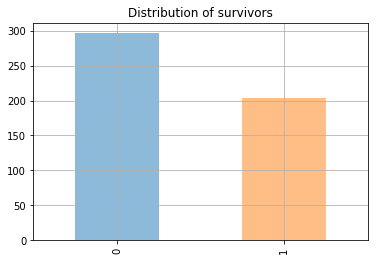

In [19]:
train_df.survived.value_counts().sort_index().plot(kind = "bar",alpha = .5)
plt.title("Distribution of survivors")
plt.grid(b = True , which = "major")

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


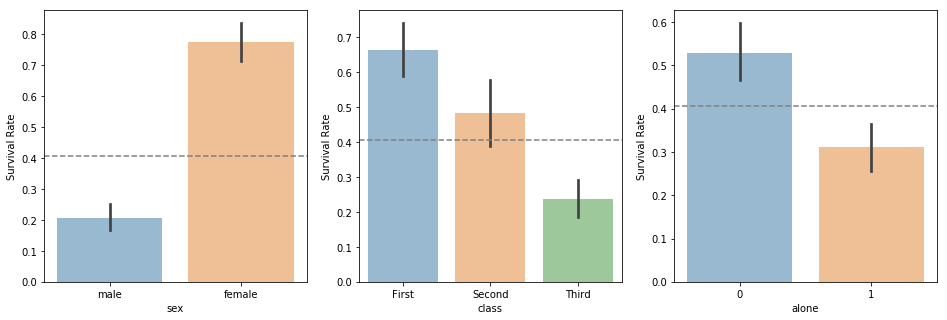

In [20]:
features = ['sex', 'class', 'alone']

# The _ is used for the first variable because we are not going
# to use it.
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

survival_rate = train_df.survived.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'survived', data=train_df, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Survival Rate')
    ax[i].axhline(survival_rate, ls='--', color='grey')

2. Create a swarmplot where the x-axis is each of the independent variable names (petal_length, petal_width, etc). The y-axis is the value of the variable. Use color to represent species as another dimension. Hint: You will to 'melt' the dataframe into a 'long' dataframe in order to accomplish this. What are your takeaways from this visualization?

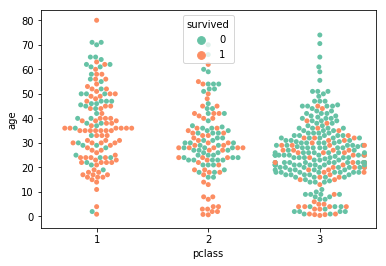

In [21]:
sns.swarmplot(x="pclass", y="age", data=train_df, hue="survived", palette="Set2")

In [22]:
df.columns

Index(['passenger_id', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'embark_town', 'alone', 'embarked_encode'],
      dtype='object')

In [23]:
df['passenger_class'] = df['class']

In [24]:
df.dtypes

passenger_id         int64
survived             int64
pclass               int64
sex                 object
age                float64
sibsp                int64
parch                int64
fare               float64
embarked            object
class               object
embark_town         object
alone                int64
embarked_encode      int64
passenger_class     object
dtype: object

In [51]:
sns.set(style="whitegrid", palette="muted")
val_vars=['pclass', 'age', 'sibsp', 'parch','fare', 
          'alone', 'embarked_encode']

# "Melt" the dataset to "long-form" representation
df_melt = pd.melt(train_df, id_vars="passenger_id", 
                  value_vars=val_vars,
                  var_name="observed_feature", 
                  value_name='value')
df_melt.head(5).append(df_melt.sample(5)).append(df_melt.tail(5))

,passenger_id,observed_feature,value
0,555,pclass,1.00
1,398,pclass,2.00
2,622,pclass,3.00
3,873,pclass,3.00
4,157,pclass,3.00
2482,386,fare,46.90
2059,491,fare,7.25
2999,371,embarked_encode,2.00
3346,809,embarked_encode,2.00
794,435,age,14.00


[Text(0, 0, 'pclass'),
 Text(0, 0, 'age'),
 Text(0, 0, 'sibsp'),
 Text(0, 0, 'parch'),
 Text(0, 0, 'fare'),
 Text(0, 0, 'alone'),
 Text(0, 0, 'embarked_encode')]

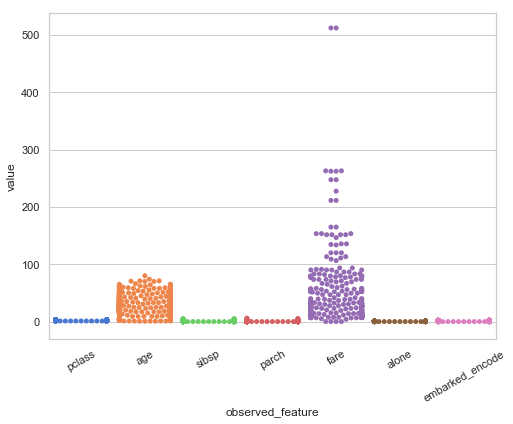

In [53]:
plt.figure(figsize=(8,6))

# Draw a categorical scatterplot to show each observation
ax = sns.swarmplot(x="observed_feature", y="value", data=df_melt)
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)

In [27]:
train_df.columns

Index(['passenger_id', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'embark_town', 'alone', 'embarked_encode'],
      dtype='object')

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


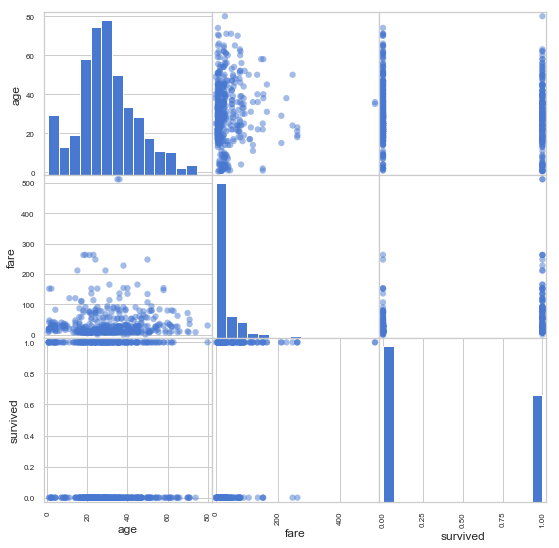

In [28]:
cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(
    train_df[['age','fare','survived']], marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)

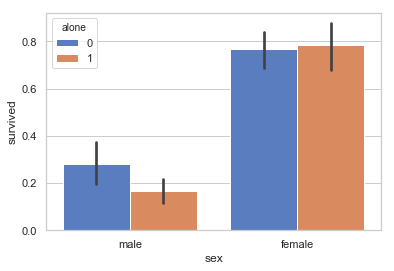

In [29]:
sns.barplot('sex', 'survived', data=train_df, hue='alone')

In [54]:
train_df.head()

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,embark_town,alone,embarked_encode
555,555,0,1,male,62.0,0,0,26.5500,S,First,Southampton,1,2
398,398,0,2,male,23.0,0,0,10.5000,S,Second,Southampton,1,2
622,622,1,3,male,20.0,1,1,15.7417,C,Third,Cherbourg,0,0
873,873,0,3,male,47.0,0,0,9.0000,S,Third,Southampton,1,2
157,157,0,3,male,30.0,0,0,8.0500,S,Third,Southampton,1,2


4. Create a heatmap of each variable layering correlation coefficient on top.

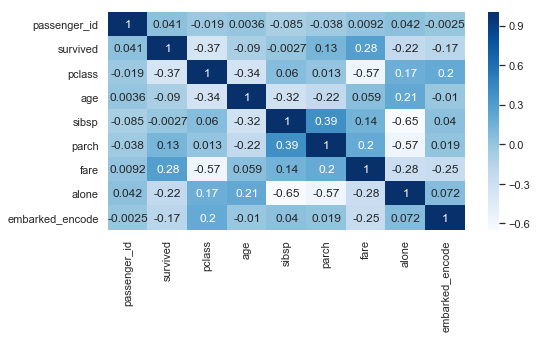

In [32]:
plt.figure(figsize=(8,4))
sns.heatmap(train_df.corr(), cmap='Blues', annot=True)

5. Create a scatter matrix visualizing the interaction of each variable

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  import sys


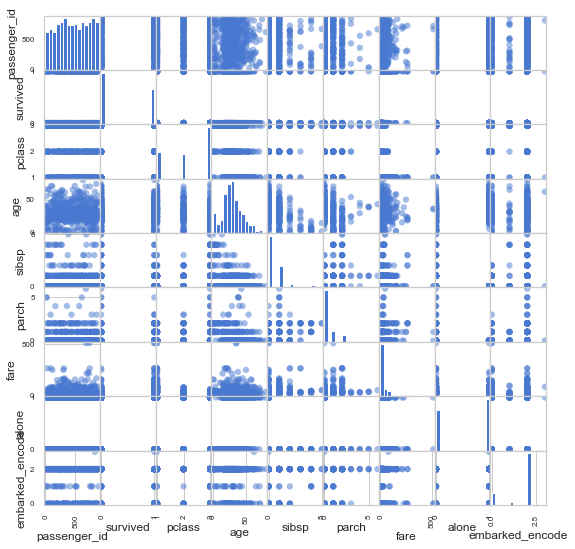

In [33]:
from pandas.tools.plotting import scatter_matrix
from matplotlib import cm

cmap = cm.get_cmap('gnuplot')
scatter = pd.scatter_matrix(
    train_df, marker='o', s=40,
    hist_kwds={'bins':15},  figsize=(9,9), cmap=cmap)

In [34]:
train_df.columns

Index(['passenger_id', 'survived', 'pclass', 'sex', 'age', 'sibsp', 'parch',
       'fare', 'embarked', 'class', 'embark_town', 'alone', 'embarked_encode'],
      dtype='object')

In [35]:
import scipy as sp 
import numpy as np

sp.stats.ttest_ind(
    train_df[train_df.survived == 1].age.dropna(),
    train_df[train_df.survived == 0].age.dropna())

# is the t-statistic < -1.96 or > 1.96?
# if so, then look at p-value to ensure it is less than our alpha of .05.
# RESULTS: Ttest_indResult(statistic=4.689639600247356, 
#                          pvalue=1.364082860373532e-05)

# t-statistic is greater than 1.96
# p-value is less than .05
# so the difference in sepal length between 
# virginica and versicolor is substantial.
# So I am rejecting the null hypothesis.

Ttest_indResult(statistic=-2.012224018867312, pvalue=0.04473535126710687)